# Concentration de CO2 dans l'atmosphère depuis 1958

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek
import numpy as np
from datetime import datetime
from scipy.signal import argrelextrema
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

## Importation des données

Les données sont disponibles sur le site du [Programme Scripps CO2](https://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo.html) au format *csv*.

In [2]:
data_url = "https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv"

Pour nous protéger contre une éventuelle disparition ou modification du serveur du Programme Scripps CO2, nous faisons une copie locale de ce jeux de données que nous préservons avec notre analyse. Il est inutile et même risquée de télécharger les données à chaque exécution, car dans le cas d'une panne nous pourrions remplacer nos données par un fichier défectueux. Pour cette raison, nous téléchargeons les données seulement si la copie locale n'existe pas. Étant donné l'évolution temporelle des données, qui sont mises à jour régulièrement, celles-ci sont téléchargées à nouveau une fois par jour.

In [3]:
data_file = "donnees-CO2-" + str(datetime.today().date().year) + "-" + str(datetime.today().date().month) + "-" + str(datetime.today().date().day) + ".csv"

import os
import urllib.request
if not os.path.exists(data_file):
    urllib.request.urlretrieve(data_url, data_file)

Les 44 premières lignes de données contiennent une description de leur contenu (auteurs/institut, date, citation, informations données).
Après ces 44 lignes, les données sont affichées directement sans titre de colonne.

Les informations sur les données sont les suivantes : *The data file below contains 2 columns indicaing the date and CO2 concentrations in micro-mol CO2 per mole (ppm), reported on the 2008A SIO manometric mole fraction scale.  These weekly values have been adjusted to 12:00 hours at middle day of each weekly period as indicated by the date in the first column.*

In [4]:
raw_data = pd.read_csv(data_file, skiprows=44, header=None)
raw_data

0       1
0     1958-03-29  316.19
1     1958-04-05  317.31
2     1958-04-12  317.69
3     1958-04-19  317.58
4     1958-04-26  316.48
5     1958-05-03  316.95
6     1958-05-17  317.56
7     1958-05-24  317.99
8     1958-07-05  315.85
9     1958-07-12  315.85
10    1958-07-19  315.46
11    1958-07-26  315.59
12    1958-08-02  315.64
13    1958-08-09  315.10
14    1958-08-16  315.09
15    1958-08-30  314.14
16    1958-09-06  313.54
17    1958-11-08  313.05
18    1958-11-15  313.26
19    1958-11-22  313.57
20    1958-11-29  314.01
21    1958-12-06  314.56
22    1958-12-13  314.41
23    1958-12-20  314.77
24    1958-12-27  315.21
25    1959-01-03  315.24
26    1959-01-10  315.50
27    1959-01-17  315.69
28    1959-01-24  315.86
29    1959-01-31  315.42
...          ...     ...
3154  2020-01-25  413.36
3155  2020-02-01  413.99
3156  2020-02-08  414.83
3157  2020-02-15  413.81
3158  2020-02-22  414.17
3159  2020-02-29  413.89
3160  2020-03-07  414.00
3161  2020-03-14  414.30
3162  2020-03-21  414.62
3163  2020-03-28  415.57
3164  2020-04-04  415.61
3165  2020-04-11  416.47
3166  2020-04-18  416.60
3167  2020-04-25  415.86
3168  2020-05-02  417.20
3169  2020-05-09  416.99
3170  2020-05-16  416.54
3171  2020-05-23  417.49
3172  2020-05-30  417.19
3173  2020-06-06  416.49
3174  2020-06-13  416.50
3175  2020-06-20  416.11
3176  2020-06-27  415.75
3177  2020-07-04  415.20
3178  2020-07-11  414.91
3179  2020-07-18  414.29
3180  2020-07-25  413.63
3181  2020-08-01  413.42
3182  2020-08-08  412.85
3183  2020-08-15  412.75

[3184 rows x 2 columns]

## Vérification des données

In [5]:
raw_data[raw_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [0, 1]
Index: []

Toutes les lignes contiennent des informations non nulles.

### Formattage de la date

In [6]:
def convert_week(year_month_day_str):
    year = int(year_month_day_str[:4])
    month = int(year_month_day_str[5:7])
    day = int(year_month_day_str[8:10])
    w = datetime(year, month, day)
    return pd.Period(w, 'W')

raw_data['period'] = [convert_week(yw) for yw in raw_data[0] ]

In [7]:
data = {'period' : raw_data['period'], 'conc' : raw_data[1]}
data = pd.DataFrame(data=data)
data = data.set_index('period').sort_index()
data

conc
period                       
1958-03-24/1958-03-30  316.19
1958-03-31/1958-04-06  317.31
1958-04-07/1958-04-13  317.69
1958-04-14/1958-04-20  317.58
1958-04-21/1958-04-27  316.48
1958-04-28/1958-05-04  316.95
1958-05-12/1958-05-18  317.56
1958-05-19/1958-05-25  317.99
1958-06-30/1958-07-06  315.85
1958-07-07/1958-07-13  315.85
1958-07-14/1958-07-20  315.46
1958-07-21/1958-07-27  315.59
1958-07-28/1958-08-03  315.64
1958-08-04/1958-08-10  315.10
1958-08-11/1958-08-17  315.09
1958-08-25/1958-08-31  314.14
1958-09-01/1958-09-07  313.54
1958-11-03/1958-11-09  313.05
1958-11-10/1958-11-16  313.26
1958-11-17/1958-11-23  313.57
1958-11-24/1958-11-30  314.01
1958-12-01/1958-12-07  314.56
1958-12-08/1958-12-14  314.41
1958-12-15/1958-12-21  314.77
1958-12-22/1958-12-28  315.21
1958-12-29/1959-01-04  315.24
1959-01-05/1959-01-11  315.50
1959-01-12/1959-01-18  315.69
1959-01-19/1959-01-25  315.86
1959-01-26/1959-02-01  315.42
...                       ...
2020-01-20/2020-01-26  413.36
2020-01-27/2020-02-02  413.99
2020-02-03/2020-02-09  414.83
2020-02-10/2020-02-16  413.81
2020-02-17/2020-02-23  414.17
2020-02-24/2020-03-01  413.89
2020-03-02/2020-03-08  414.00
2020-03-09/2020-03-15  414.30
2020-03-16/2020-03-22  414.62
2020-03-23/2020-03-29  415.57
2020-03-30/2020-04-05  415.61
2020-04-06/2020-04-12  416.47
2020-04-13/2020-04-19  416.60
2020-04-20/2020-04-26  415.86
2020-04-27/2020-05-03  417.20
2020-05-04/2020-05-10  416.99
2020-05-11/2020-05-17  416.54
2020-05-18/2020-05-24  417.49
2020-05-25/2020-05-31  417.19
2020-06-01/2020-06-07  416.49
2020-06-08/2020-06-14  416.50
2020-06-15/2020-06-21  416.11
2020-06-22/2020-06-28  415.75
2020-06-29/2020-07-05  415.20
2020-07-06/2020-07-12  414.91
2020-07-13/2020-07-19  414.29
2020-07-20/2020-07-26  413.63
2020-07-27/2020-08-02  413.42
2020-08-03/2020-08-09  412.85
2020-08-10/2020-08-16  412.75

[3184 rows x 1 columns]

### Vérification de l'écart temporel entre les données

In [8]:
def ecart_temporel(date1, date2):
    year1 = int(str(date1)[:4])
    month1 = int(str(date1)[5:7])
    day1 = int(str(date1)[8:10])
    year2 = int(str(date2)[:4])
    month2 = int(str(date2)[5:7])
    day2 = int(str(date2)[8:10])
    return (datetime(year1,month1,day1)-datetime(year2,month2,day2)).days

delta_t = [ecart_temporel(data.index[i+1],data.index[i]) for i in range(0,len(data)-1)]
delta_t

[7,
 7,
 7,
 7,
 7,
 14,
 7,
 42,
 7,
 7,
 7,
 7,
 7,
 7,
 14,
 7,
 63,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 14,
 7,
 7,
 7,
 14,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 14,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 14,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 28,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 14,
 7,
 7,
 7,
 7,
 7,
 14,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 14,
 7,
 7,
 7,
 7,
 7,


Certaines données sont manquantes.
Tous les delta_t sont cependant des multiples de 7 ce qui signifie qu'il n'y a pas eu de décalage dans les données.

## Un premier coup d'oeil aux données

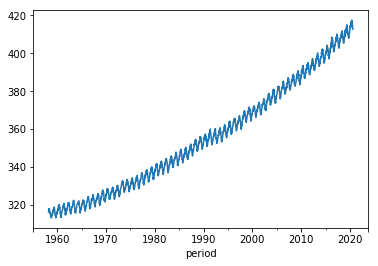

In [9]:
data['conc'].plot()

## Caractérisation de l'oscillation périodique

On observe en effet une oscillation superposée à une évolution temporelle plus lente.
Zoomons sur quelques années afin de voir l'oscillation plus clairement.

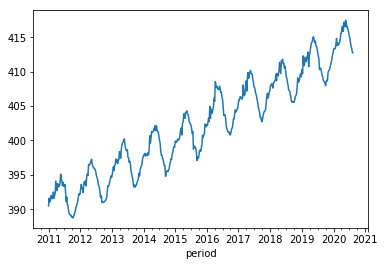

In [10]:
data['conc'][-500:].plot()

### Période d'oscillation

Une observation visuelle nous indique que l'oscillation a une période proche d'un an.
Les cycles terrestres (saisons, courants, etc...) étant pour la plupart cycliques avec une période d'un an, je fais l'hypothèse que c'est le cas ici.
Afin de vérifier cette hypothèse, je vais localiser le maximum et le minimum de la concentration en CO2 chaque année (l'année est déterminée par le premier jour de la semaine considérée - cela ne devrait pas amener de problème car les extremums annuels ne sont pas situés fin décembre/début janvier).
L'écart entre les maximums et entre les minimums nous indiquera si mon hypothèse est vérifiée.

Les années 1958 et 2020 sont ignorées car elles sont incomplètes.

In [11]:
year = [int(str(data.index[i])[:4]) for i in range(0,len(data))]
max_index = [int(year.index(i)) + int(np.array(data[year.index(i):year.index(i+1)-1]).argmax(axis=0)) for i in range(1959,2020)]
min_index = [int(year.index(i)) + int(np.array(data[year.index(i):year.index(i+1)-1]).argmin(axis=0)) for i in range(1959,2020)]

delta_t_max = [ecart_temporel(data.index[max_index][i+1],data.index[max_index][i]) for i in range(0,len(max_index)-1)]
delta_t_min = [ecart_temporel(data.index[min_index][i+1],data.index[min_index][i]) for i in range(0,len(min_index)-1)]

In [12]:
np.mean(delta_t_max), np.std(delta_t_max)

(365.4, 18.06488306078952)

In [13]:
np.mean(delta_t_min), np.std(delta_t_min)

(365.28333333333336, 11.816784202518422)

L'écart entre les maximums annuels étant exactement égal à 1 an (365,25 j), l'hypothèse faite plus haut et validée et je conclus que **la période des oscillations est d'un an.**

### Amplitude d'oscillation

Afin de calculer l'amplitude des oscillations, nous devons soustraire la moyenne annuelle de la concentration à cette concentration. Cela permet d'isoler les oscillations dans le signal. Pour les mêmes raisons que précédemment, les années 1958 et 2020 sont ignorées.

In [14]:
yearly_average = [np.mean(data['conc'][year.index(i):year.index(i+1)-1])  for i in range(1958,2020)]
yearly_average.append(np.mean(data['conc'][year.index(2020):]))
data['yearly_average'] = [yearly_average[int(year[i])-1958] for i in range(0,len(data))]
data['oscillations'] = data['conc'] - data['yearly_average']

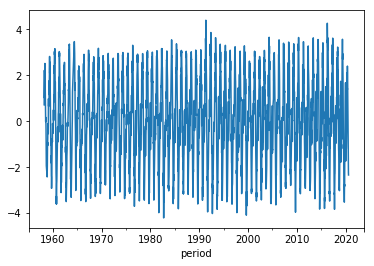

In [15]:
data['oscillations'].plot()
Amplitude = [0.5 * ( data['oscillations'][max_index][i] - data['oscillations'][min_index][i] ) for i in range(0,len(max_index))]

In [16]:
np.mean(Amplitude), np.std(Amplitude)

(3.3075609079445134, 0.2844505794603768)

**L'amplitude d'oscillation est en moyenne de 3,30 ppm, et varie avec un écart-type de 0.28 ppm.**

## Modèle simple de l'évolution lente de la concentration

### Visualisation des données

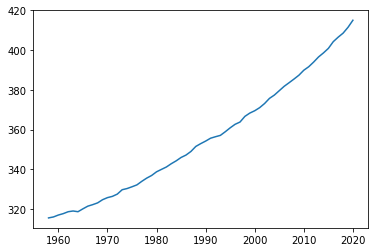

In [17]:
plt.plot(range(1958,2021),yearly_average)

### Deux modèles envisagés

A vue d'oeil il est compliqué de savoir si l'évolution lente de la concentration suit une évolution parabolique ou exponentielle.
Nous allons donc comparer ces deux modèles afin de déterminer celui qui est le plus adapté.

In [18]:
# Définition des fonctions pour le fitting
def func_parab(x, a, b, c):
    return a*np.power(x,2) + b*x + c
def func_exp(x, a, b, c):
    return a * np.exp(b * x) + c

# Définition des variables à fitter
xdata = range(0,len(yearly_average)-2)
ydata = yearly_average[1:len(yearly_average)-1]

**Estimation des points de départ pour le fitting :**

A partir de la courbe précédente, j'ai choisi les points suivants afin d'estimer grossièrement les paramètres du fitting : (0, 320), (20, 340), et (30, 360).
Un changement de variable est fait pour les valeurs de x en faisant commencer x à 0 au lieu de 1959. 

Il faut résoudre le système d'équation suivant : { f(0) = 320, f(20) = 340, f(30) = 360 pour f représentant les fonctions parabolique et exponentielle.

Le résultat obtenu pour le modèle parabolique est a = 5.45e-2 ppm/an2, b = - 9.1e-2 ppm/an, et c = 320 ppm.
Pour le modèle exponentiel, le résultat obtenu est a = 4 ppm, b = 0.3 an-1, et c = 316 ppm.

In [19]:
# Fit
popt_parab, pcov_parab = curve_fit(func_parab, xdata, ydata, p0 = [0.0545, -0.091, 320])
popt_exp, pcov_exp = curve_fit(func_exp, xdata, ydata, p0 = [4, 0.3, 316])

### Visualisation des données fittées

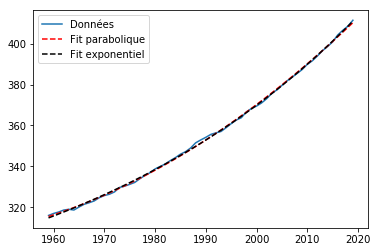

In [20]:
# Plot
plt.plot(range(1959,2020), ydata, label='Données')
plt.plot(range(1959,2020), func_parab(xdata, *popt_parab), 'r--', label='Fit parabolique')
plt.plot(range(1959,2020), func_exp(xdata, *popt_exp), 'k--', label='Fit exponentiel')
plt.legend()

Il n'y a pas de différence visuelle significative entre les deux fit.
Il est cependant intéressant de noter que la tendance globale de l'évolution lente est bien reproduite dans les deux cas.

Nous allons maintenant comparer la moyenne et l'écart-type de l'erreur entre les données et leur fitting.

In [21]:
err_parab = ydata - func_parab(xdata, *popt_parab)
err_exp = ydata - func_exp(xdata, *popt_exp)

np.mean(err_parab), np.mean(err_exp), np.std(err_parab), np.std(err_exp)

(1.230054309774862e-13,
 -7.491403490259144e-11,
 0.6795969684950424,
 0.6623123190021285)

Dans les deux cas, l'erreur moyenne est très faible (inférieure à 1e-10 en valeur absolue) et les écarts-types sont similaires (avec un léger avantage pour la méthode exponentielle).
**La méthode choisie pour la modélisation est la méthode exponentielle**, mais elle restera comparée à la méthode parabolique (par curiosité essentiellement).

## Extrapolation jusqu'à 2025

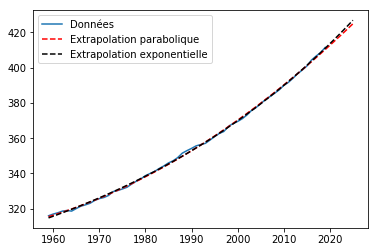

In [22]:
plt.plot(range(1959,2020), ydata, label='Données')
plt.plot(range(1959,2026), func_parab(range(0,len(range(1959,2026))), *popt_parab), 'r--', label='Extrapolation parabolique')
plt.plot(range(1959,2026), func_exp(range(0,len(range(1959,2026))), *popt_exp), 'k--', label='Extrapolation exponentielle')
plt.legend()

L'année 2025 correspond à l'index 67 du vecteur (1959 1960 ... 2025).

In [23]:
func_parab(67,*popt_parab), func_exp(67,*popt_exp)

(427.44379606384007, 429.7446447207408)

**Un modèle simple basé sur une fonction exponentielle permet d'extrapoler la valeur de la concentration de CO2 en 2025 et donne la valeur suivante : 429.7 ppm.**

Le modèle parabolique donne une valeur proche (mais qui commence à diverger du modèle exponentiel) : 427.4 ppm.
L'inspection visuelle donne aussi l'impression que l'extrapolation exponentielle suit mieux la dynamique de la courbe de concentration.